In [2]:
#Question_11
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt
import numpy as np
import os

def probability_func(currentS, nextS, move, w):
    l = currentS + actions[0]
    u = currentS + actions[1]
    r = currentS + actions[2]
    d = currentS + actions[3]
    if nextS == l:
        if move == 0:
            return 1-w+w/4
        else:
            return w/4
    elif nextS == u:
        if move == 1:
            return 1-w+w/4
        else:
            return w/4
    elif nextS == r:
        if move == 2:
            return 1-w+w/4
        else:
            return w/4
    elif nextS == d:
        if move == 3:
            return 1-w+w/4
        else:
            return w/4
    elif nextS == currentS:
        rec = 0
        if l < 0:
            if move == 0:
                rec += (1-w+w/4)
            else:
                rec += w/4
        if r > 99:
            if move == 2:
                rec += (1-w+w/4)
            else:
                rec += w/4
        if u % 10 == 9:
            if move == 1:
                rec += (1-w+w/4)
            else:
                rec += w/4
        if d % 10 == 0:
            if move == 3:
                rec += (1-w+w/4)
            else:
                rec += w/4
        return rec
    else:
        return 0


def comp(currentS, move, w, gamma, reward, vals):
    l = currentS + actions[0]
    r = currentS + actions[2]
    u = currentS + actions[1]
    d = currentS + actions[3]
    neighbours = [l, r, u, d, currentS]
    res = 0
    for neighbour in neighbours:
        if neighbour < 0 or neighbour > 99 or (currentS % 10 == 0 and neighbour % 10 == 9) or (currentS % 10 == 9 and neighbour % 10 == 0):
            continue
        res += probability_func(currentS, neighbour, move, w) * (reward[neighbour] + gamma * vals[neighbour])
    return res


def optimal_state_value(vals, w, gamma, reward, thresh):
    for s in range(100):
        vals[s] = 0
    delta = float('inf')
    while delta > thresh:
        delta = 0
        tmp = vals[:]
        for s in range(100):
            v = vals[s]
            vals[s] = max(comp(s, 0, w, gamma, reward, tmp),
                                comp(s, 1, w, gamma, reward, tmp),
                                comp(s, 2, w, gamma, reward, tmp),
                                comp(s, 3, w, gamma, reward, tmp))
            delta = max(delta, abs(v - vals[s]))
    return vals

def matrix_raw(leng, w, direc):
    s = leng * leng
    result = np.zeros(s * s).reshape(s, s)
    main_possibility = 1 - w
    random_possibility = w / 4
    for row in range(s):
        nexts = next_s(leng, row)
        if direc == "up":
            result[row][nexts[0]] = main_possibility
        elif direc == "down":
            result[row][nexts[1]] = main_possibility
        elif direc == "left":
            result[row][nexts[2]] = main_possibility
        elif direc == "right":
            result[row][nexts[3]] = main_possibility
        for col in nexts:
            result[row][col] += random_possibility
    return result
        
    
def next_s(leng, cur_s):
    x = cur_s % leng
    y = cur_s // leng
    u = cur_s - 1
    d = cur_s + 1
    l = cur_s - leng
    r = cur_s + leng
    if x == 0:
        u = cur_s
    if x == leng - 1:
        d = cur_s
    if y == 0:
        l = cur_s
    if y == leng - 1:
        r = cur_s
    return np.array([u, d, l, r])

def get_c_d_b(expert_action, P_actions, lambda_val, rmax):
    P_exp = []
    P_ags = []
    P_ags.append([])
    P_ags.append([])
    P_ags.append([])
    for s in range(100):
        exp_action = expert_action[s]
        agent = 0
        for act in range(4):
            if act == exp_action:
                P_exp.append(P_actions[act][s])
            else:
                P_ags[agent].append(P_actions[act][s])
                agent += 1

    I = np.eye(100)
    z = np.zeros(100 * 100).reshape(100, 100)
    D = np.concatenate((z, z, z, z))
    D = np.concatenate((D, np.concatenate((-I, -I, z, z)), 
                        np.concatenate((I, -I, I, -I))), 1)
 
    for P_ag in P_ags:
        tmp = np.dot((np.array(P_ag) - np.array(P_exp)), 
                      np.linalg.inv(np.eye(100) - 0.8 * np.array(P_exp)))
        tmp_row1 = np.concatenate((I, z, tmp), 1)
        tmp_row2 = np.concatenate((z, z, tmp), 1)
        tmp = np.concatenate((tmp_row1, tmp_row2))
        D = np.concatenate((tmp, D))
        
    c1 = np.array([1. for _ in range(100)])
    c2 = np.array([-lambda_val for _ in range(100)])
    c3 = np.array([0.0 for _ in range(100)])
    c = np.concatenate((c1, c2, c3), axis=0)
    c = -c
    b1 = np.array([0.0 for _ in range(800)])
    b2 = np.array([rmax for _ in range(200)])
    b = np.concatenate((b1, b2), axis=0)
    return c, D, b

def get_reward_func(c, D, b):
    A = matrix(D)
    b = matrix(b)
    c = matrix(c)
    solvers.options['show_progress'] = False
    sol=solvers.lp(c,A,b)
    return sol['x'][-100:]

def sweep(expert_action, rmax):
    accuracy_list = []
    lambda_list = []
    lam = 0
    for i in range(501):
        c, D, b = get_c_d_b(expert_action, P_actions, lam, rmax)
        reward_func = np.array(get_reward_func(c, D, b))
        val = optimal_state_value(vals, w, gamma, reward_func, thres)
        agent_action = [0 for _ in range(100)]
        for s in range(100):
            agent_action[s] = np.argmax([comp(s, 0, w, gamma, reward_func, val),
                                             comp(s, 1, w, gamma, reward_func, val),
                                             comp(s, 2, w, gamma, reward_func, val),
                                             comp(s, 3, w, gamma, reward_func, val)])
        cnt = 0
        for j, k in zip(expert_action, agent_action):
            if j == k:
                cnt += 1
        accuracy = cnt / len(agent_action)
        
        print("lambda: " + str(lam) + "  acc: " + str(accuracy))
        accuracy_list.append(acc)
        lambda_list.append(lam)
        lam += 0.01
    return lambda_list, accuracy_list

In [1]:
vals = [0 for _ in range(100)]
thres = 0.01
actions = [-10, -1, 10, 1] 
w = 0.1
gamma = 0.8

lambda: 0  acc: 0.82
lambda: 0.01  acc: 0.81
lambda: 0.02  acc: 0.81
lambda: 0.03  acc: 0.81
lambda: 0.04  acc: 0.81
lambda: 0.05  acc: 0.81
lambda: 0.060000000000000005  acc: 0.73
lambda: 0.07  acc: 0.73
lambda: 0.08  acc: 0.73
lambda: 0.09  acc: 0.73
lambda: 0.09999999999999999  acc: 0.73
lambda: 0.10999999999999999  acc: 0.73
lambda: 0.11999999999999998  acc: 0.73
lambda: 0.12999999999999998  acc: 0.73
lambda: 0.13999999999999999  acc: 0.73
lambda: 0.15  acc: 0.73
lambda: 0.16  acc: 0.73
lambda: 0.17  acc: 0.73
lambda: 0.18000000000000002  acc: 0.73
lambda: 0.19000000000000003  acc: 0.74
lambda: 0.20000000000000004  acc: 0.72
lambda: 0.21000000000000005  acc: 0.72
lambda: 0.22000000000000006  acc: 0.73
lambda: 0.23000000000000007  acc: 0.73
lambda: 0.24000000000000007  acc: 0.73
lambda: 0.25000000000000006  acc: 0.73
lambda: 0.26000000000000006  acc: 0.73
lambda: 0.2700000000000001  acc: 0.73
lambda: 0.2800000000000001  acc: 0.73
lambda: 0.2900000000000001  acc: 0.73
lambda: 0.30000

lambda: 2.2199999999999966  acc: 0.92
lambda: 2.2299999999999964  acc: 0.93
lambda: 2.239999999999996  acc: 0.92
lambda: 2.249999999999996  acc: 0.92
lambda: 2.259999999999996  acc: 0.92
lambda: 2.2699999999999956  acc: 0.92
lambda: 2.2799999999999954  acc: 0.92
lambda: 2.289999999999995  acc: 0.92
lambda: 2.299999999999995  acc: 0.92
lambda: 2.3099999999999947  acc: 0.92
lambda: 2.3199999999999945  acc: 0.92
lambda: 2.3299999999999943  acc: 0.93
lambda: 2.339999999999994  acc: 0.92
lambda: 2.349999999999994  acc: 0.92
lambda: 2.3599999999999937  acc: 0.92
lambda: 2.3699999999999934  acc: 0.92
lambda: 2.3799999999999932  acc: 0.92
lambda: 2.389999999999993  acc: 0.92
lambda: 2.399999999999993  acc: 0.92
lambda: 2.4099999999999926  acc: 0.92
lambda: 2.4199999999999924  acc: 0.92
lambda: 2.429999999999992  acc: 0.92
lambda: 2.439999999999992  acc: 0.92
lambda: 2.4499999999999917  acc: 0.92
lambda: 2.4599999999999915  acc: 0.92
lambda: 2.4699999999999913  acc: 0.92
lambda: 2.4799999999999

lambda: 4.41999999999995  acc: 0.9
lambda: 4.42999999999995  acc: 0.9
lambda: 4.43999999999995  acc: 0.91
lambda: 4.4499999999999496  acc: 0.9
lambda: 4.459999999999949  acc: 0.91
lambda: 4.469999999999949  acc: 0.91
lambda: 4.479999999999949  acc: 0.91
lambda: 4.489999999999949  acc: 0.91
lambda: 4.4999999999999485  acc: 0.9
lambda: 4.509999999999948  acc: 0.91
lambda: 4.519999999999948  acc: 0.91
lambda: 4.529999999999948  acc: 0.92
lambda: 4.539999999999948  acc: 0.92
lambda: 4.549999999999947  acc: 0.91
lambda: 4.559999999999947  acc: 0.92
lambda: 4.569999999999947  acc: 0.92
lambda: 4.579999999999947  acc: 0.92
lambda: 4.589999999999947  acc: 0.92
lambda: 4.599999999999946  acc: 0.92
lambda: 4.609999999999946  acc: 0.92
lambda: 4.619999999999946  acc: 0.91
lambda: 4.629999999999946  acc: 0.92
lambda: 4.6399999999999455  acc: 0.92
lambda: 4.649999999999945  acc: 0.92
lambda: 4.659999999999945  acc: 0.92
lambda: 4.669999999999945  acc: 0.92
lambda: 4.679999999999945  acc: 0.91
lambd

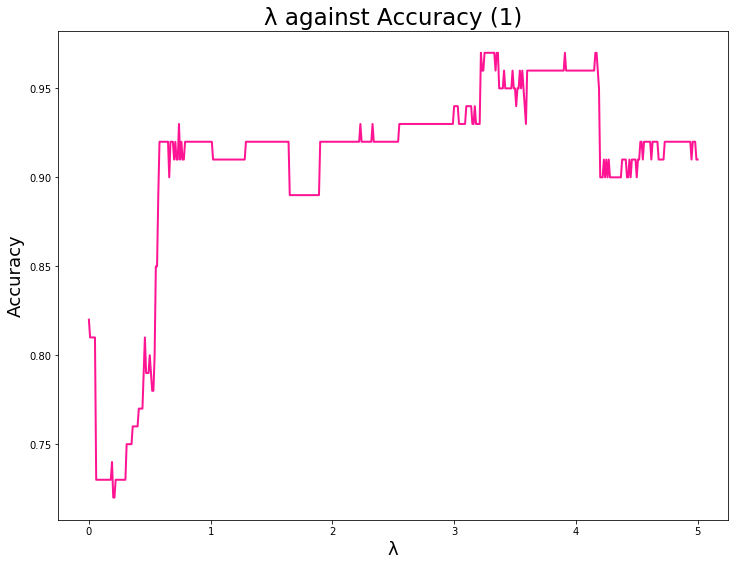

In [7]:



reward1 = [[0 for _ in range(10)] for _ in range(10)]
reward1[9][9] = 1
reward_1 = []
reward1 = np.array(reward1).transpose()
for lines in reward1:
    reward_1 += list(lines)
expert_action = [0 for _ in range(100)]
vals = optimal_state_value(vals, w, gamma, reward_1, thres)
for s in range(100):
    expert_action[s] = np.argmax([comp(s, 0, w, gamma, reward_1, vals),
                                   comp(s, 1, w, gamma, reward_1, vals),
                                   comp(s, 2, w, gamma, reward_1, vals),
                                   comp(s, 3, w, gamma, reward_1, vals)])

    
P_actions = []
P_actions.append(matrix_raw(10, 0.1, "left"))
P_actions.append(matrix_raw(10, 0.1, "up"))
P_actions.append(matrix_raw(10, 0.1, "right"))
P_actions.append(matrix_raw(10, 0.1, "down"))
lambda_list, accuracy_list = sweep(expert_action, 1.0)
plt.figure(figsize=(12,9))
plt.xlabel('λ', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.title('λ against Accuracy (1)', fontsize=23)
plt.plot(lambda_list, accuracy_list, color="deeppink", lw=2)
plt.show()

In [8]:
#question_12
max_ind = np.argmax(accuracy_list)
lambda_max = lambda_list[max_ind]
print(lambda_max)

3.2199999999999753


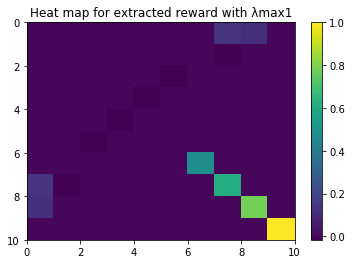

In [9]:
#question_13
c_opt, D_opt, b_opt = get_c_d_b(expert_action, P_actions, lambda_max, 1.0)
reward_opt = np.array(get_reward_func(c_opt, D_opt, b_opt))
reward_opt_graph = reward_opt.reshape(10, 10).T

plt.pcolor(reward_opt_graph)
plt.gca().invert_yaxis()
plt.colorbar()
plt.title("Heat map for extracted reward with λmax1")
plt.show()

Text(0.5, 1.0, 'Heat map for optimal state values for extracted reward function1')

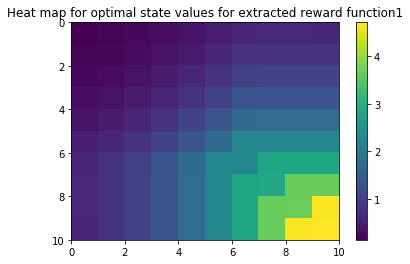

In [10]:
#question_14
vals = optimal_state_value(vals, w, gamma, reward_opt, thres)
g1 = np.round(vals, decimals=3).reshape(10, 10).transpose()

plt.figure()
plt.pcolor(g1)
plt.gca().invert_yaxis()
plt.colorbar()
plt.title("Heat map for optimal state values for extracted reward function1")

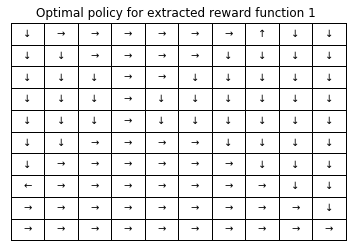

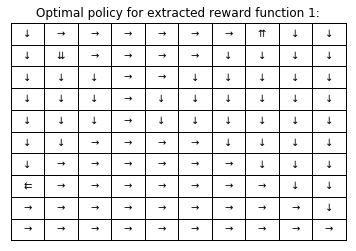

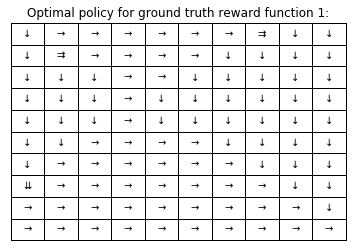

In [11]:
# question_16
pis = [0 for _ in range(100)]
arrows = ['\u2190', '\u2191', '\u2192', '\u2193']
for s in range(100):
    pis[s] = arrows[np.argmax([comp(s, 0, w, gamma, reward_opt, vals),
                                   comp(s, 1, w, gamma, reward_opt, vals),
                                   comp(s, 2, w, gamma, reward_opt, vals),
                                   comp(s, 3, w, gamma, reward_opt, vals)])]
    
    
reward1 = [[0 for _ in range(10)] for _ in range(10)]
reward1[9][9] = 1
reward_1 = []
reward1 = np.array(reward1).transpose()
for lines in reward1:
    reward_1 += list(lines)
vals = optimal_state_value(vals, w, gamma, reward_1, thres)
pis2 = [0 for _ in range(100)]
arrows = ['\u2190', '\u2191', '\u2192', '\u2193']
for s in range(100):
    pis2[s] = arrows[np.argmax([comp(s, 0, w, gamma, reward_1, vals),
                                    comp(s, 1, w, gamma, reward_1, vals),
                                    comp(s, 2, w, gamma, reward_1, vals),
                                    comp(s, 3, w, gamma, reward_1, vals)])]
    
pi0 = np.array(pis).reshape(10, 10).transpose()
pi1 = np.array(pis).reshape(10, 10).transpose()
pi2 = np.array(pis2).reshape(10, 10).transpose()

plt.figure()
tb = plt.table(cellText=pi0, loc=(0,0), cellLoc='center')
tc = tb.properties()['child_artists']
plt.title("Optimal policy for extracted reward function 1 ")
for cell in tc:
    cell.set_height(0.1)
    cell.set_width(0.1)
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.show()

plt.figure()
tb = plt.table(cellText=pi1, loc=(0,0), cellLoc='center')
tc = tb.properties()['child_artists']
plt.title("Optimal policy for extracted reward function 1:")
for cell in tc:
    cell.set_height(0.1)
    cell.set_width(0.1)
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])

plt.figure()
tb2 = plt.table(cellText=pi2, loc=(0,0), cellLoc='center')
tc2 = tb2.properties()['child_artists']
plt.title("Optimal policy for ground truth reward function 1:")
for cell in tc2:
    cell.set_height(0.1)
    cell.set_width(0.1)
    
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [12]:
# question_18
reward2 = [[0 for _ in range(10)] for _ in range(10)]
reward2[1][4:7] = [-100 for _ in range(3)]
reward2[2][4] = -100
reward2[2][6] = -100
reward2[3][4] = -100
reward2[3][6:9] = [-100 for _ in range(3)]
reward2[4][4] = -100
reward2[4][8] = -100
reward2[5][4] = -100
reward2[5][8] = -100
reward2[6][4] = -100
reward2[6][8] = -100
reward2[7][6:9] = [-100 for _ in range(3)]
reward2[8][6] = -100
reward2[9][9] = 10
reward_2 = []
reward2 = np.array(reward2).transpose()
for lines in reward2:
    reward_2 += list(lines)

expert_action2 = [0 for _ in range(100)]
vals = optimal_state_value(vals, w, gamma, reward_2, thres)
for s in range(100):
    expert_action2[s] = np.argmax([comp(s, 0, w, gamma, reward_2, vals),
                                   comp(s, 1, w, gamma, reward_2, vals),
                                   comp(s, 2, w, gamma, reward_2, vals),
                                   comp(s, 3, w, gamma, reward_2, vals)])

lambda_list2, accuracy_list2 = sweep(expert_action2, 100)



lambda: 0  acc: 0.82
lambda: 0.01  acc: 0.8
lambda: 0.02  acc: 0.78
lambda: 0.03  acc: 0.79
lambda: 0.04  acc: 0.78
lambda: 0.05  acc: 0.78
lambda: 0.060000000000000005  acc: 0.8
lambda: 0.07  acc: 0.84
lambda: 0.08  acc: 0.83
lambda: 0.09  acc: 0.83
lambda: 0.09999999999999999  acc: 0.84
lambda: 0.10999999999999999  acc: 0.83
lambda: 0.11999999999999998  acc: 0.81
lambda: 0.12999999999999998  acc: 0.81
lambda: 0.13999999999999999  acc: 0.79
lambda: 0.15  acc: 0.79
lambda: 0.16  acc: 0.81
lambda: 0.17  acc: 0.81
lambda: 0.18000000000000002  acc: 0.82
lambda: 0.19000000000000003  acc: 0.82
lambda: 0.20000000000000004  acc: 0.83
lambda: 0.21000000000000005  acc: 0.82
lambda: 0.22000000000000006  acc: 0.83
lambda: 0.23000000000000007  acc: 0.83
lambda: 0.24000000000000007  acc: 0.83
lambda: 0.25000000000000006  acc: 0.89
lambda: 0.26000000000000006  acc: 0.89
lambda: 0.2700000000000001  acc: 0.88
lambda: 0.2800000000000001  acc: 0.88
lambda: 0.2900000000000001  acc: 0.88
lambda: 0.3000000

lambda: 2.2199999999999966  acc: 0.91
lambda: 2.2299999999999964  acc: 0.91
lambda: 2.239999999999996  acc: 0.91
lambda: 2.249999999999996  acc: 0.9
lambda: 2.259999999999996  acc: 0.9
lambda: 2.2699999999999956  acc: 0.9
lambda: 2.2799999999999954  acc: 0.9
lambda: 2.289999999999995  acc: 0.91
lambda: 2.299999999999995  acc: 0.91
lambda: 2.3099999999999947  acc: 0.89
lambda: 2.3199999999999945  acc: 0.91
lambda: 2.3299999999999943  acc: 0.91
lambda: 2.339999999999994  acc: 0.89
lambda: 2.349999999999994  acc: 0.9
lambda: 2.3599999999999937  acc: 0.91
lambda: 2.3699999999999934  acc: 0.77
lambda: 2.3799999999999932  acc: 0.77
lambda: 2.389999999999993  acc: 0.79
lambda: 2.399999999999993  acc: 0.78
lambda: 2.4099999999999926  acc: 0.78
lambda: 2.4199999999999924  acc: 0.58
lambda: 2.429999999999992  acc: 0.59
lambda: 2.439999999999992  acc: 0.59
lambda: 2.4499999999999917  acc: 0.59
lambda: 2.4599999999999915  acc: 0.56
lambda: 2.4699999999999913  acc: 0.56
lambda: 2.479999999999991  a

lambda: 4.42999999999995  acc: 0.6
lambda: 4.43999999999995  acc: 0.6
lambda: 4.4499999999999496  acc: 0.6
lambda: 4.459999999999949  acc: 0.6
lambda: 4.469999999999949  acc: 0.6
lambda: 4.479999999999949  acc: 0.6
lambda: 4.489999999999949  acc: 0.6
lambda: 4.4999999999999485  acc: 0.6
lambda: 4.509999999999948  acc: 0.6
lambda: 4.519999999999948  acc: 0.61
lambda: 4.529999999999948  acc: 0.61
lambda: 4.539999999999948  acc: 0.61
lambda: 4.549999999999947  acc: 0.61
lambda: 4.559999999999947  acc: 0.61
lambda: 4.569999999999947  acc: 0.61
lambda: 4.579999999999947  acc: 0.61
lambda: 4.589999999999947  acc: 0.61
lambda: 4.599999999999946  acc: 0.61
lambda: 4.609999999999946  acc: 0.61
lambda: 4.619999999999946  acc: 0.61
lambda: 4.629999999999946  acc: 0.61
lambda: 4.6399999999999455  acc: 0.61
lambda: 4.649999999999945  acc: 0.61
lambda: 4.659999999999945  acc: 0.61
lambda: 4.669999999999945  acc: 0.6
lambda: 4.679999999999945  acc: 0.6
lambda: 4.689999999999944  acc: 0.6
lambda: 4.69

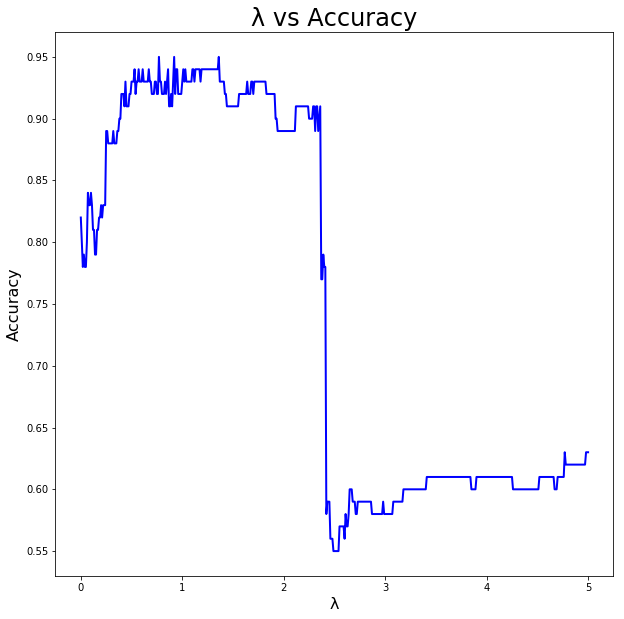

In [13]:
plt.figure(figsize=(10,10))
plt.xlabel('λ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('λ vs Accuracy', fontsize=24)
plt.plot(lambda_list2, accuracy_list2, color="blue", lw=2)
plt.show()

In [20]:
#question_19
print(np.max(accuracy_list2))
max_ind2 = np.argmax(accuracy_list2)
lambda_max2 = lambda_list2[max_ind2]
print(lambda_max2)

0.95
0.7700000000000005


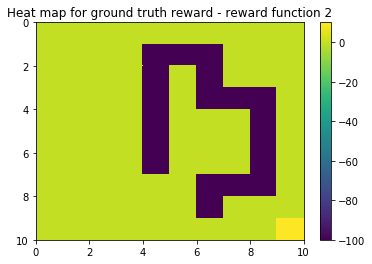

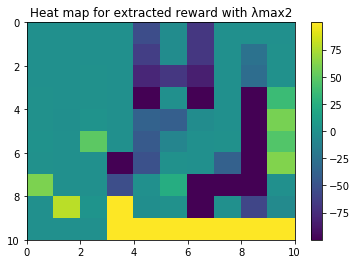

[]

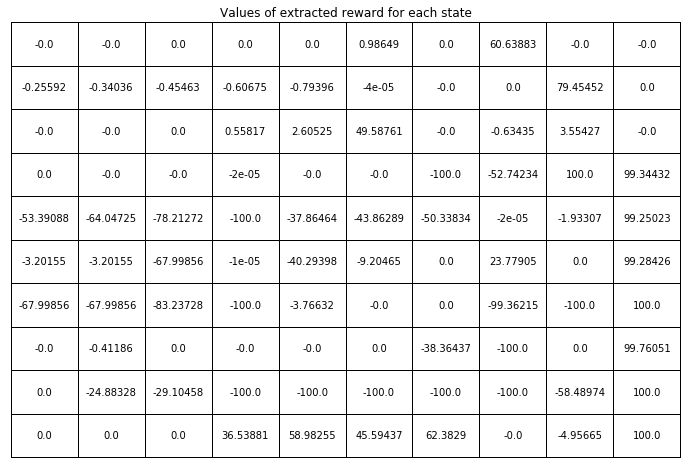

In [30]:
#question_20
reward2 = [[0 for _ in range(10)] for _ in range(10)]
reward2[1][4:7] = [-100 for _ in range(3)]
reward2[2][4] = -100
reward2[2][6] = -100
reward2[3][4] = -100
reward2[3][6:9] = [-100 for _ in range(3)]
reward2[4][4] = -100
reward2[4][8] = -100
reward2[5][4] = -100
reward2[5][8] = -100
reward2[6][4] = -100
reward2[6][8] = -100
reward2[7][6:9] = [-100 for _ in range(3)]
reward2[8][6] = -100
reward2[9][9] = 10
plt.pcolor(reward2)
plt.gca().invert_yaxis()
plt.colorbar()
plt.title("Heat map for ground truth reward - reward function 2")
plt.show()

c_opt2, D_opt2, b_opt2 = get_c_d_b(expert_action2, P_actions, lambda_max2, 100)
reward_opt2 = np.array(get_reward_func(c_opt2, D_opt2, b_opt2))
reward_opt_graph2 = reward_opt2.reshape(10, 10).T
plt.pcolor(reward_opt_graph2)
plt.gca().invert_yaxis()
plt.colorbar()
plt.title("Heat map for extracted reward with λmax2")
plt.show()

g1 = np.round(reward_opt_graph2, decimals=5).reshape(10, 10).transpose()
plt.figure(figsize=(12,8))
tb = plt.table(cellText=g1, loc=(0,0), cellLoc='center')
tc = tb.properties()['child_artists']
plt.title("Values of extracted reward for each state")
for cell in tc:
    cell.set_height(0.1)
    cell.set_width(0.1)
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])

Text(0.5, 1.0, 'Heat Map of Optimal State Values for Extracted Reward Function2')

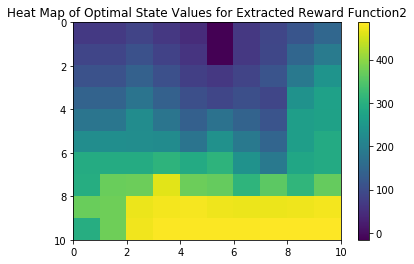

In [31]:
#question_21
vals = optimal_state_value(vals, w, gamma, reward_opt2, thres)
g1 = np.round(vals, decimals=10).reshape(10, 10).transpose()
plt.figure()
plt.pcolor(g1)
plt.gca().invert_yaxis()
plt.colorbar()
plt.title("Heat Map of Optimal State Values for Extracted Reward Function2")

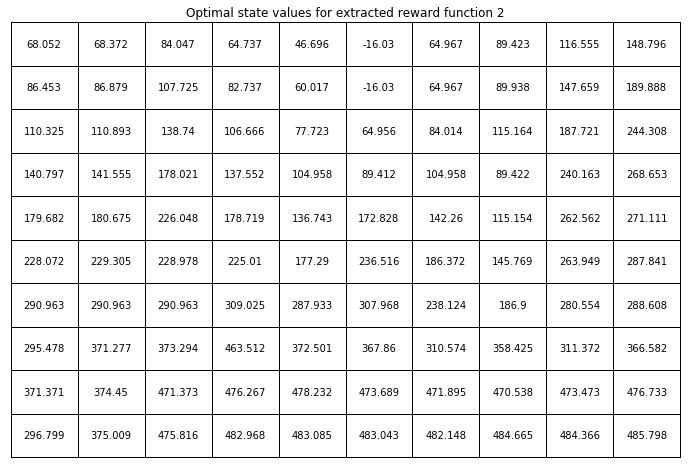

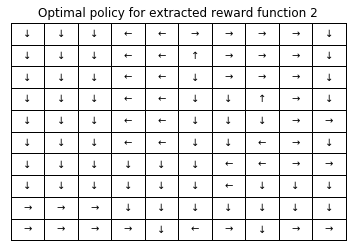

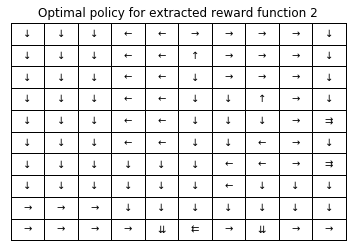

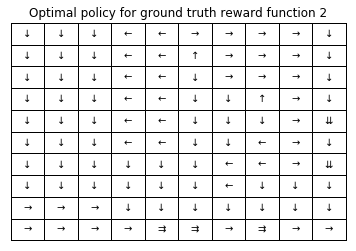

In [32]:
#question_23
vals = optimal_state_value(vals, w, gamma, reward_opt2, thres)

g1 = np.round(vals, decimals=3).reshape(10, 10).transpose()
plt.figure(figsize=(12,8))
tb = plt.table(cellText=g1, loc=(0,0), cellLoc='center')
tc = tb.properties()['child_artists']
plt.title("Optimal state values for extracted reward function 2")
for cell in tc:
    cell.set_height(0.1)
    cell.set_width(0.1)
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])

pis = [0 for _ in range(100)]
arrows = ['\u2190', '\u2191', '\u2192', '\u2193']
for s in range(100):
    pis[s] = arrows[np.argmax([comp(s, 0, w, gamma, reward_opt2, vals),
                                   comp(s, 1, w, gamma, reward_opt2, vals),
                                   comp(s, 2, w, gamma, reward_opt2, vals),
                                   comp(s, 3, w, gamma, reward_opt2, vals)])]

reward2 = [[0 for _ in range(10)] for _ in range(10)]
reward2[1][4:7] = [-100 for _ in range(3)]
reward2[2][4] = -100
reward2[2][6] = -100
reward2[3][4] = -100
reward2[3][6:9] = [-100 for _ in range(3)]
reward2[4][4] = -100
reward2[4][8] = -100
reward2[5][4] = -100
reward2[5][8] = -100
reward2[6][4] = -100
reward2[6][8] = -100
reward2[7][6:9] = [-100 for _ in range(3)]
reward2[8][6] = -100
reward2[9][9] = 10
reward_2 = []
reward2 = np.array(reward2).transpose()
for lines in reward2:
    reward_2 += list(lines)

vals = optimal_state_value(vals, w, gamma, reward_2, thres)

pis2 = [0 for _ in range(100)]
arrows = ['\u2190', '\u2191', '\u2192', '\u2193']
for s in range(100):
    pis2[s] = arrows[np.argmax([comp(s, 0, w, gamma, reward_2, vals),
                                   comp(s, 1, w, gamma, reward_2, vals),
                                   comp(s, 2, w, gamma, reward_2, vals),
                                   comp(s, 3, w, gamma, reward_2, vals)])]

        
pi0 = np.array(pis).reshape(10, 10).transpose()
pi1 = np.array(pis).reshape(10, 10).transpose()
pi2 = np.array(pis2).reshape(10, 10).transpose()

plt.figure()
tb = plt.table(cellText=pi0, loc=(0,0), cellLoc='center')
tc = tb.properties()['child_artists']
plt.title("Optimal policy for extracted reward function 2")
for cell in tc:
    cell.set_height(0.1)
    cell.set_width(0.1)
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.show()

plt.figure()
tb = plt.table(cellText=pi1, loc=(0,0), cellLoc='center')
tc = tb.properties()['child_artists']
plt.title("Optimal policy for extracted reward function 2")
for cell in tc:
    cell.set_height(0.1)
    cell.set_width(0.1)
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])

plt.figure()
tb2 = plt.table(cellText=pi2, loc=(0,0), cellLoc='center')
tc2 = tb2.properties()['child_artists']
plt.title("Optimal policy for ground truth reward function 2")
for cell in tc2:
    cell.set_height(0.1)
    cell.set_width(0.1)
    
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [ ]:
#end